In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif', size = 18)

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal

from fxpmath import Fxp

import funcs
import importlib
importlib.reload(funcs)  # Importing the latest version of funcs.py

<module 'funcs' from '/home/urosminoski/Desktop/FAKS/MASTER/All-Digital-RF-Transmitter-in-FPGA-master-/sim/v1.4/python/jupyter/funcs.py'>

In [3]:
# Filter coefficients
b = [3.19382974, -8.02002256, 8.73762976, -4.61756997, 0.97458298]
a = [1, -1.63632004, 1.47600867, -0.75840147, 0.2125798, -0.02541702]

In [4]:
# Decompos IIR filter to parallel IIR sections
[b_parallel, a_parallel] = funcs.decompose_iir_to_parallel(b, a)

print("Parallel Decomposition:")
for i in range(len(a_parallel)):
    print("Section " + str(i+1) + ":")
    print("\tb =", b_parallel[i])
    print("\ta =", a_parallel[i], "\n")

Parallel Decomposition:
Section 1:
	b = [7.376738447284568]
	a = [1, -0.3466037644977315] 

Section 2:
	b = [0.42386913756811406, -2.782525031028174]
	a = [1, -0.6659138380831608, 0.1626025786310818] 

Section 3:
	b = [-4.606777844852687, 0.023283687418655274]
	a = [1, -0.623802437419108, 0.45098689983844903] 



In [16]:
N = 8*1024
M = 3
OSR = 8
n = np.arange(N)

x = 2**(M-1) * np.sin(2*np.pi*np.floor(2/7 * N/OSR) * n/N)
xfxp = [Fxp(val, signed=True, n_word=12, n_frac=8, overflow='saturate', rounding='around') for val in x]

yfxp = funcs.deltaSigma(xfxp)

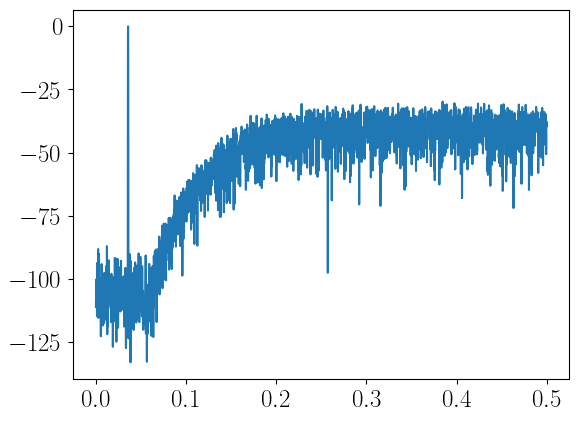

In [17]:
w = signal.blackman(len(yfxp), False)
yfxp_fft = np.fft.fft(yfxp*w)
yfxp_fft_dB = 20*np.log10(np.abs(yfxp_fft))
yfxp_fft_dB -= np.max(yfxp_fft_dB)
yfxp_fft_dB = yfxp_fft_dB[:N//2]

plt.plot(np.linspace(0, 0.5, N//2), yfxp_fft_dB)

In [14]:
def deltaSigma(x, n_word, n_frac, overflow='saturate', rounding='around'):
    # Coefficients of H0.
    b00 = Fxp(7.3765809, n_word=12, n_frac=8, overflow='saturate', rounding='around')
    a01 = Fxp(0.3466036, n_word=12, n_frac=11, overflow='saturate', rounding='around')
    # Coefficients of H1.
    b10 = Fxp(0.424071040, n_word=12, n_frac=11, overflow='saturate', rounding='around')
    b11 = Fxp(2.782608716, n_word=12, n_frac=9, overflow='saturate', rounding='around')
    a11 = Fxp(0.66591402, n_word=12, n_frac=11, overflow='saturate', rounding='around')
    a12 = Fxp(0.16260264, n_word=12, n_frac=11, overflow='saturate', rounding='around')
    # Coefficients of H2.
    b20 = Fxp(4.606822182, n_word=12, n_frac=8, overflow='saturate', rounding='around')
    b21 = Fxp(0.023331537, n_word=12, n_frac=11, overflow='saturate', rounding='around')
    a21 = Fxp(0.62380242, n_word=12, n_frac=11, overflow='saturate', rounding='around')
    a22 = Fxp(0.4509869, n_word=12, n_frac=11, overflow='saturate', rounding='around')
    
    y_iir = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    e = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    y_i = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    x0 = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    x0d = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    x1 = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    w1 = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    w1d = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    w1dd = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    x2 = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    w2 = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    w2d = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    w2dd = Fxp(0, n_word=24, n_frac=19, overflow='saturate', rounding='around')
    v = Fxp(0, n_word=4, n_frac=0, overflow='saturate', rounding='around')
    
    y = np.zeros(len(x))
    
    for i in range(len(x)):
        y_i( (x[i]+y_iir)() )
        v( y_i() )
        # if v() % 2 == 0:
        #     v( (v+1)() )
        y[i] = v()
        e( (y_i-v)() )
    
        x0( (b00*e+a01*x0d)() )
        w1( (e+a11*w1d-a12*w1dd)() )
        x1( (b10*w1-b11*w1d)() )
        w2( (e+a21*w2d-a22*w2dd)() )
        x2( (b21*w2d-b20*w2)() )
        y_iir( (x0+x1+x2)() )
    
        x0d( x0() )
        w1dd( w1d() )
        w1d( w1() )
        w2dd( w2d() )
        w2d( w2() )
    return y

N = 1*1024
M = 3
OSR = 8
n = np.arange(N)

x = 2**(M-1) * np.sin(2*np.pi*np.floor(2/7 * N/OSR) * n/N)
xfxp = [Fxp(val, signed=True, n_word=12, n_frac=8, overflow='saturate', rounding='around')() for val in x]

yfxp = deltaSigma(xfxp, 0, 0)

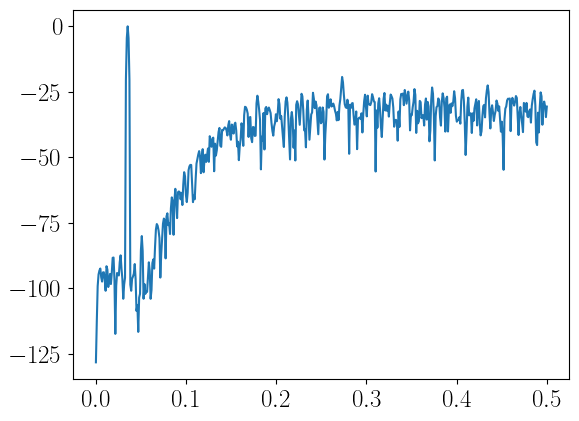

In [15]:
w = signal.blackman(len(yfxp), False)
yfxp_fft = np.fft.fft(yfxp*w)
yfxp_fft_dB = 20*np.log10(np.abs(yfxp_fft))
yfxp_fft_dB -= np.max(yfxp_fft_dB)
yfxp_fft_dB = yfxp_fft_dB[:N//2]

plt.plot(np.linspace(0, 0.5, N//2), yfxp_fft_dB)